In [1]:
from dotenv import load_dotenv
import os 
from agents import Agent,Runner,trace, OpenAIChatCompletionsModel,function_tool
from openai import AsyncOpenAI
from typing import Dict
from openai.types.responses import ResponseTextDeltaEvent
import requests
import asyncio
import joblib
from prophet import Prophet

c:\Users\shawn\OneDrive\Desktop\NewProject\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
groq_api_key=os.getenv("GROQ_API_KEY")
GROQ_BASE_URL="https://api.groq.com/openai/v1"

In [4]:
groq_client=AsyncOpenAI(base_url=GROQ_BASE_URL,api_key=groq_api_key)
llama_3_model=OpenAIChatCompletionsModel(model="llama-3.1-8b-instant",openai_client=groq_client)

In [5]:
import pandas as pd 

In [6]:
df=pd.read_csv("C:\\Users\\shawn\\OneDrive\\Desktop\\NewProject\\SEPTA_MODEL\\Artifacts\\train.csv")

In [7]:
df

,Route,ds,y
0,32,2020-01-01,5101
1,T2,2020-01-01,12048
2,T5,2020-01-01,13871
3,61,2020-01-01,4607
4,127,2020-01-01,297
...,...,...,...
8681,59,2025-04-01,3350
8682,80,2025-04-01,119
8683,98,2025-04-01,575
8684,118,2025-04-01,349


In [50]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
last_date = df['ds'].max()


In [51]:
@function_tool
def get_forecasts(route_number:int,months_ahead:int):
    """  Forecasts ridership numbers of a given route number in given months_ahead from now """
    model=joblib.load(f"C:\\Users\\shawn\\OneDrive\\Desktop\\NewProject\\SEPTA_MODEL\\Artifacts\\models\\route_{route_number}.pkl")
    print(f"route number is {route_number} and months ahead is {months_ahead}")
    future = model.make_future_dataframe(periods=months_ahead, freq='M')
    forecast = model.predict(future)
    plt.figure(figsize=(20, 6))


    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')

    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                    color='blue', alpha=0.2, label='Confidence Interval')

    forecast_start = last_date
    forecast_end = forecast['ds'].max()

    plt.axvspan(forecast_start, forecast_end, color='orange', alpha=0.1, label='Forecast Period')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

    plt.xticks(rotation=45)

    plt.title('Ridership Forecast with Highlighted Forecast Period')
    plt.xlabel('Date')
    plt.ylabel('Ridership')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()
    return {"success":"ok"}




In [52]:
tools=[get_forecasts]

In [53]:
instructions=""" 
You are an expert agent working for SEPTA. You can forecast ridership data 
    for any route number. When users ask for forecasts, extract the route id
      and months ahead, then use the get_forecasts function. Do not make multiple calls.
"""

septa_agent=Agent(
    name="SEPTA_AGENT",
    instructions=instructions,
    model=llama_3_model,
    tools=tools
    )

route number is 150 and months ahead is 3


c:\Users\shawn\OneDrive\Desktop\NewProject\venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


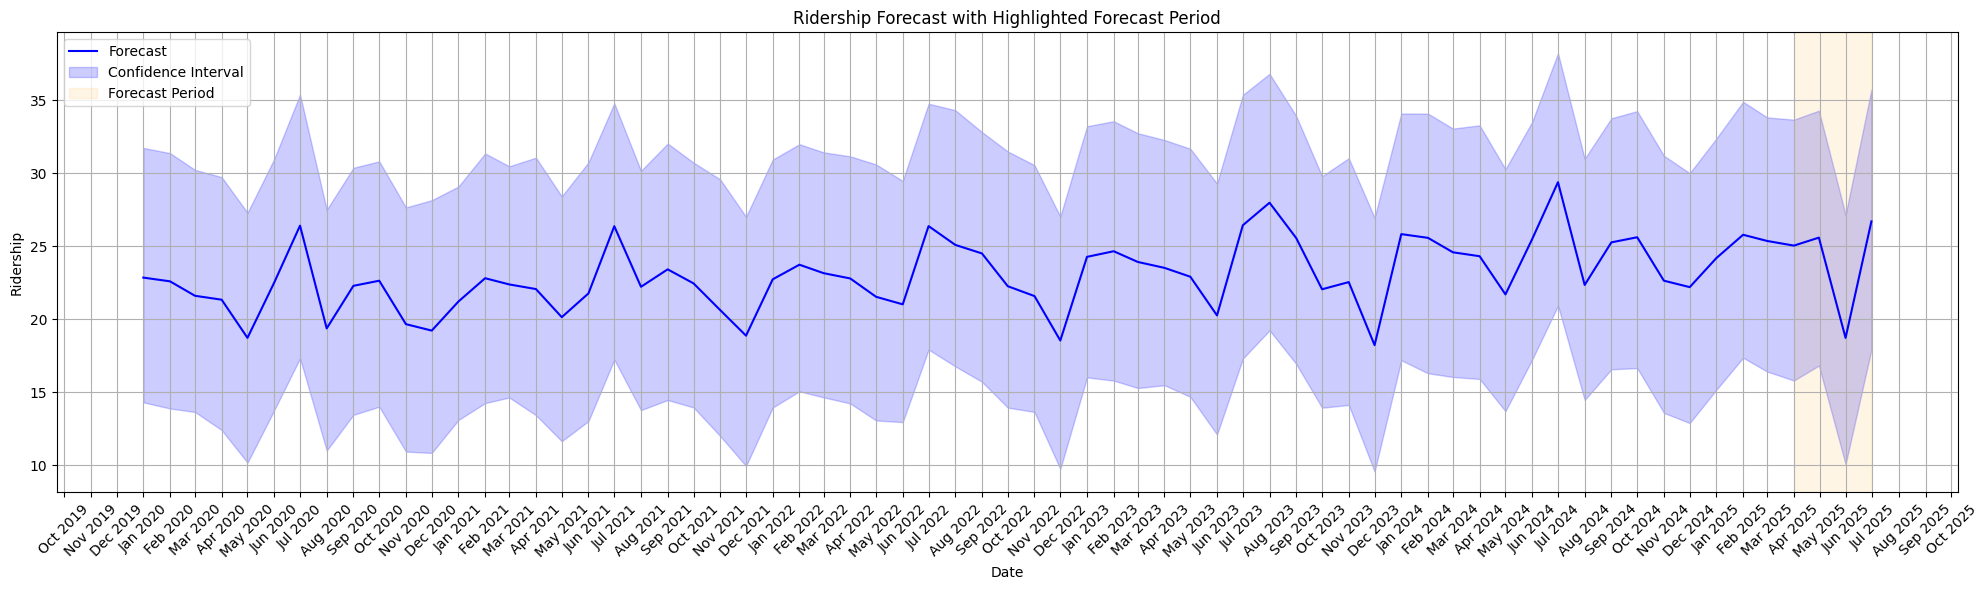

In [56]:
message="Tell me the next 3 month forecasts for route 150"

result= await Runner.run(septa_agent,message)

In [24]:
result

RunResult(input='Tell me the next 3 month forecasts for route 1', new_items=[ToolCallItem(agent=Agent(name='SEPTA_AGENT', instructions=' \nYou are an expert agent working for SEPTA. You can forecast ridership data \n    for any route number. When users ask for forecasts, extract the route number \n    (as integer) and months ahead, then use the get_forecasts function.\n', prompt=None, handoff_description=None, handoffs=[], model=<agents.models.openai_chatcompletions.OpenAIChatCompletionsModel object at 0x000002695F05CDD0>, model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None, include_usage=None, extra_query=None, extra_body=None, extra_headers=None, extra_args=None), tools=[FunctionTool(name='get_forecasts', description='Forecasts ridership numbers of a given route number in given months_ahead from now', params_json

In [22]:
model = joblib.load(f"C:\\Users\\shawn\\OneDrive\\Desktop\\NewProject\\SEPTA_MODEL\\Artifacts\\models\\route_45.pkl")
future = model.make_future_dataframe(periods=3, freq='M')
forecast = model.predict(future)

c:\Users\shawn\OneDrive\Desktop\NewProject\venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [27]:
import matplotlib.pyplot as plt

In [29]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,2988.289430,2758.106475,4601.919111,2988.289430,2988.289430,706.032411,706.032411,706.032411,706.032411,706.032411,706.032411,0.0,0.0,0.0,3694.321841
1,2020-02-01,3025.614053,2979.071164,4706.417057,3025.614053,3025.614053,835.040593,835.040593,835.040593,835.040593,835.040593,835.040593,0.0,0.0,0.0,3860.654646
2,2020-03-01,3060.530636,2988.469374,4691.847150,3060.530636,3060.530636,757.523787,757.523787,757.523787,757.523787,757.523787,757.523787,0.0,0.0,0.0,3818.054423
3,2020-04-01,3097.855259,1395.813504,3234.661179,3097.855259,3097.855259,-749.580822,-749.580822,-749.580822,-749.580822,-749.580822,-749.580822,0.0,0.0,0.0,2348.274437
4,2020-05-01,3133.975862,1500.527349,3296.036725,3133.975862,3133.975862,-774.367433,-774.367433,-774.367433,-774.367433,-774.367433,-774.367433,0.0,0.0,0.0,2359.608429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,2025-03-01,5259.117386,4427.413525,6182.944800,5259.117386,5259.117386,80.742339,80.742339,80.742339,80.742339,80.742339,80.742339,0.0,0.0,0.0,5339.859725
63,2025-04-01,5296.442912,3719.485832,5551.670682,5296.442912,5296.442912,-666.786768,-666.786768,-666.786768,-666.786768,-666.786768,-666.786768,0.0,0.0,0.0,4629.656144
64,2025-04-30,5331.360340,4212.392895,6017.002865,5331.360327,5331.360350,-192.659320,-192.659320,-192.659320,-192.659320,-192.659320,-192.659320,0.0,0.0,0.0,5138.701019
65,2025-05-31,5368.685866,3463.473521,5250.560863,5368.685819,5368.685907,-1013.282679,-1013.282679,-1013.282679,-1013.282679,-1013.282679,-1013.282679,0.0,0.0,0.0,4355.403186


In [31]:
last_date = df['ds'].max()


In [32]:
last_date

'2025-04-01'

In [36]:
import matplotlib.dates as mdates


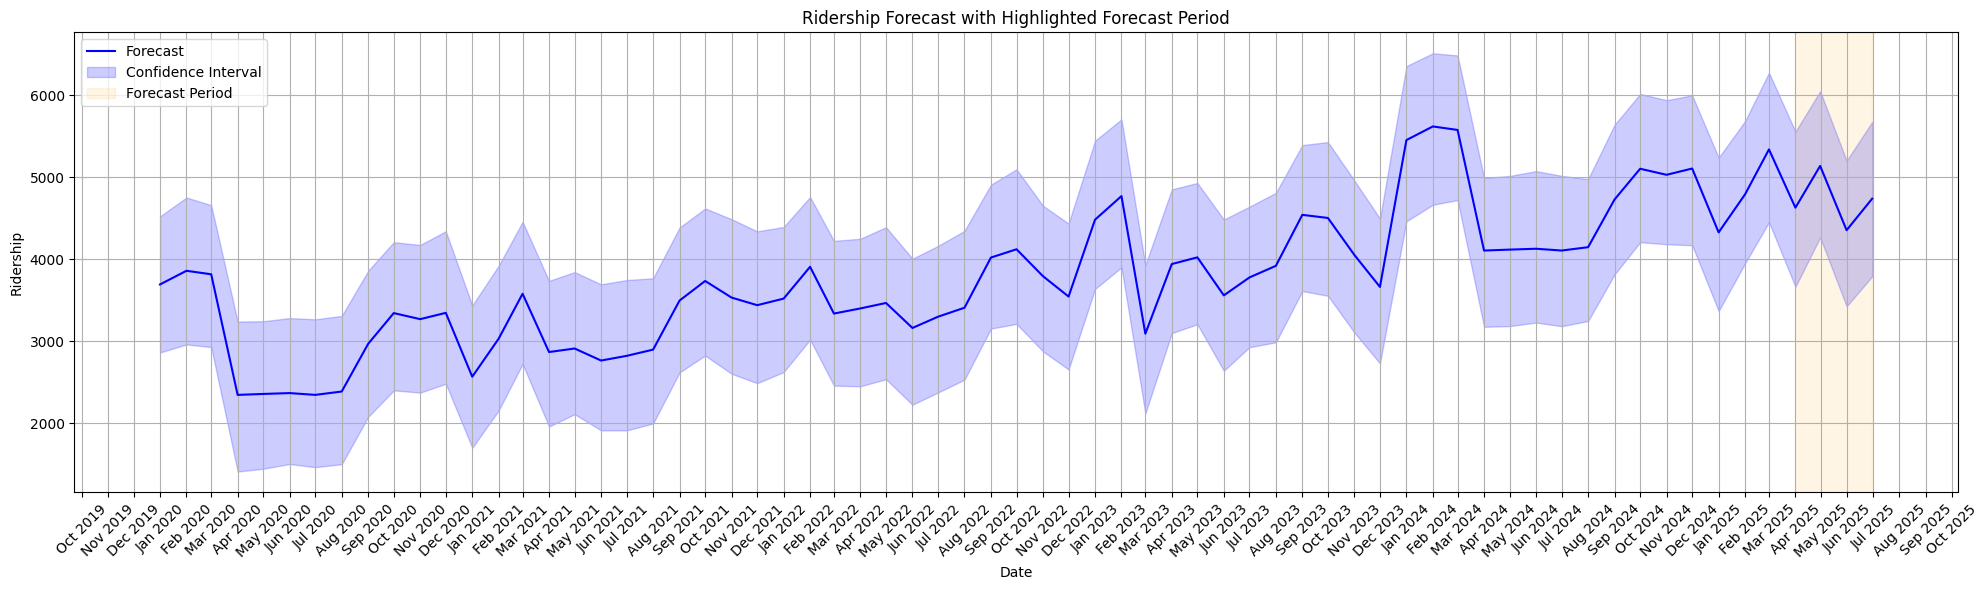

In [ ]:
plt.figure(figsize=(20, 6))


plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='blue', alpha=0.2, label='Confidence Interval')

forecast_start = last_date
forecast_end = forecast['ds'].max()

plt.axvspan(forecast_start, forecast_end, color='orange', alpha=0.1, label='Forecast Period')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=45)

plt.title('Ridership Forecast with Highlighted Forecast Period')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [80]:
load_dotenv()

True

In [79]:
from tavily import TavilyClient
tavily_api=os.getenv("TAVILY_API")

In [92]:
@function_tool
def get_information_about_routes(route_number: str,message: str):
     df=pd.read_csv("C:\\Users\\shawn\\OneDrive\\Desktop\\NewProject\\SEPTA_MODEL\\Artifacts\\output.csv")
     print("found data")
     extracted=df[df['Route']==route_number]
     csv_text = extracted.to_csv(index=False)
     return {"data":csv_text}

@function_tool
def search_web(question: str):
    tavily_client = TavilyClient(api_key=tavily_api)
    response = tavily_client.search(question)
    return {"response":response}


In [93]:
tools=[get_information_about_routes,search_web]

In [94]:
instructions=""" 
You are an expert agent working for SEPTA (Southeastern Pennsylvania Transportation Authority). 
You can answer questions about SEPTA routes using the provided data.
You can add , subtract do anything.

When a user asks about a specific route:
1. Extract the route number/ID from their question
2. Use the get_information_about_routes function to retrieve the data
3. Analyze the returned data and provide a proper response. 
4. Only make one function call per question

If the user asks general questions about the SEPTA route call the search_web function by providing a question to it and use 
the context provided to answer the user's question.

Be helpful, informative, and professional in your responses.
"""

septa_agent=Agent(
    name="info",
    instructions=instructions,
    model=llama_3_model,
    tools=tools
    )

In [95]:
message="any reason why did the septa ridership for route 1 decrease so drastically in april 2020"
result=await Runner.run(septa_agent,message)

In [96]:
result.final_output

'The drastic decrease in SEPTA ridership for Route 1 in April 2020 was likely due to the COVID-19 pandemic. According to the search engine results, transit ridership dropped significantly for all SEPTA transit types from March to April 2020, with City ridership dropping by 86%, Suburban ridership dropping by 87%, and Regional Rail ridership dropping by about 90%. This suggests that the pandemic had a significant impact on public transportation usage across the SEPTA system, including Route 1.'

In [46]:
df=pd.read_csv("C:\\Users\\shawn\\OneDrive\\Desktop\\NewProject\\SEPTA_MODEL\\Artifacts\\output.csv")


In [47]:
df[df['Route']=='1']

,Calendar_Year,Calendar_Month,Route,Average_Daily_Ridership,Source,ObjectId
59,2020,1,1,2668,APC,1615
68,2020,2,1,2712,APC,1749
409,2020,4,1,566,APC,2017
431,2020,3,1,2389,APC,1883
561,2020,8,1,1050,MODE_Report_Estimate,2553
...,...,...,...,...,...,...
7802,2024,12,1,2344,APC,9606
8010,2025,1,1,2311,APC,9745
8113,2025,3,1,2549,APC,10023
8354,2025,2,1,2467,APC,9884


In [74]:
load_dotenv()

True

In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("C:\\Users\\shawn\\OneDrive\\Desktop\\NewProject\\SEPTA_MODEL\\Artifacts\\output.csv")


In [3]:
df['Route'].unique()

array(['32', 'T2', 'T5', '61', '127', '7', '23', '28', '60', '106', '107',
       '82', '25', '45', '50', '55', '66', '94', '105', '71', 'LUCYGR',
       '16', '24', '39', '49', '64', '17', '22', '78', '92', '125', '20',
       '26', '44', '46', '58', '95', '117', '119', '132', '31', '37',
       '43', '51', '29', '73', '96', '110', '1', '53', '67', '99', '118',
       '133', '206', 'T4', '19', '33', '59', '88', '97', '113', '124',
       '204', '27', '47', '70', '130', '47M', 'BLVDDIR', '4', '8', 'T3',
       '52', '68', 'D1', '104', '108', '2', '112', '311', '81', '14',
       '18', '40', 'D2', '128', 'K', 'T1', '56', '79', '89', '120', '126',
       '80', '90', '5', '38', '57', '114', 'L1 OWL', 'G1', '62', '115',
       '54', '65', '30', '35', '48', '150', '201', '98', '310', '9', '12',
       '63', '21', '84', '42', '93', '75', '123', '129', '6', '131', '3',
       '103', '111', 'B1 OWL', 'LUCYGO', '139', '109', '41', '77', '135',
       'B', 'L1', 'M1', 'School', 'RRD'], dtype=obj